In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import spearmanr
import networkx as nx
from collections import defaultdict

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 模拟开源社区数据
def generate_community_data(n_developers=50, n_projects=20):
    """
    生成模拟的开源社区数据
    - developers: 开发者
    - projects: 项目
    - contributions: 贡献关系
    """
    np.random.seed(42)
    
    # 生成开发者技能矩阵 (开发者 x 技术标签)
    developer_skills = np.random.rand(n_developers, 5)  # 5种技术标签
    
    # 生成项目技术需求矩阵 (项目 x 技术标签)
    project_requirements = np.random.rand(n_projects, 5)
    
    # 生成贡献关系矩阵 (开发者 x 项目)
    contributions = np.zeros((n_developers, n_projects))
    for i in range(n_developers):
        for j in range(n_projects):
            # 基于技能匹配度生成贡献关系
            skill_match = np.dot(developer_skills[i], project_requirements[j])
            if skill_match > 0.6 and np.random.random() > 0.3:
                contributions[i, j] = np.random.randint(1, 10)
    
    return developer_skills, project_requirements, contributions

# 生成数据
dev_skills, proj_reqs, contributions = generate_community_data()

print("开发者技能矩阵形状:", dev_skills.shape)
print("项目需求矩阵形状:", proj_reqs.shape)
print("贡献矩阵形状:", contributions.shape)
print(f"非零贡献关系数量: {np.count_nonzero(contributions)}")

开发者技能矩阵形状: (50, 5)
项目需求矩阵形状: (20, 5)
贡献矩阵形状: (50, 20)
非零贡献关系数量: 628


=== MDS多维缩放分析 ===


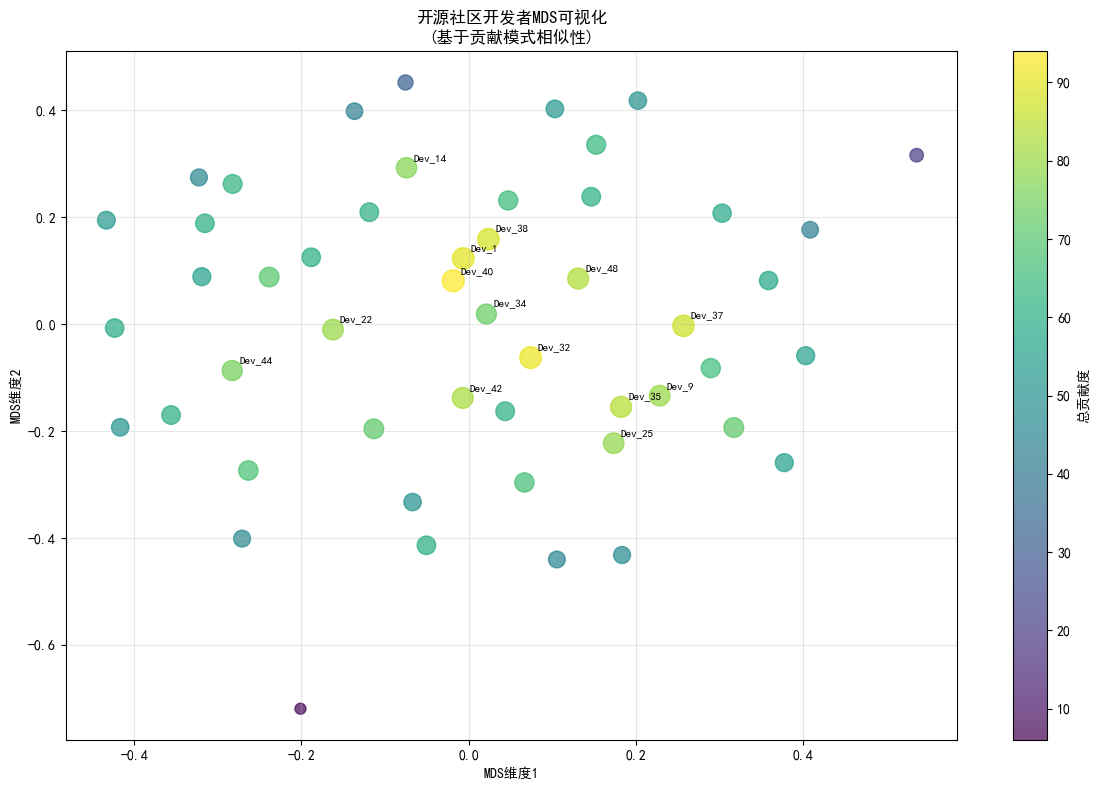

In [2]:
def mds_analysis(contributions, developer_names=None):
    """
    使用MDS对开发者进行降维可视化
    """
    print("=== MDS多维缩放分析 ===")
    
    # 计算开发者之间的相似性矩阵 (基于贡献模式的余弦相似度)
    similarity_matrix = cosine_similarity(contributions)
    
    # 执行MDS降维
    mds = MDS(n_components=2, random_state=42, dissimilarity='precomputed')
    # 将相似性转换为距离
    distance_matrix = 1 - similarity_matrix
    mds_coordinates = mds.fit_transform(distance_matrix)
    
    # 可视化
    plt.figure(figsize=(12, 8))
    
    if developer_names is None:
        developer_names = [f'Dev_{i}' for i in range(len(contributions))]
    
    # 计算每个开发者的总贡献度用于点的大小
    total_contributions = np.sum(contributions, axis=1)
    sizes = 50 + 200 * total_contributions / np.max(total_contributions)
    
    scatter = plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], 
                         s=sizes, alpha=0.7, c=total_contributions, 
                         cmap='viridis')
    
    # 添加标签
    for i, name in enumerate(developer_names):
        if total_contributions[i] > np.percentile(total_contributions, 70):  # 只标注高贡献者
            plt.annotate(name, (mds_coordinates[i, 0], mds_coordinates[i, 1]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.colorbar(scatter, label='总贡献度')
    plt.title('开源社区开发者MDS可视化\n(基于贡献模式相似性)')
    plt.xlabel('MDS维度1')
    plt.ylabel('MDS维度2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return mds_coordinates, similarity_matrix

# 执行MDS分析
mds_coords, similarity_mat = mds_analysis(contributions)

=== 相关性分析 ===


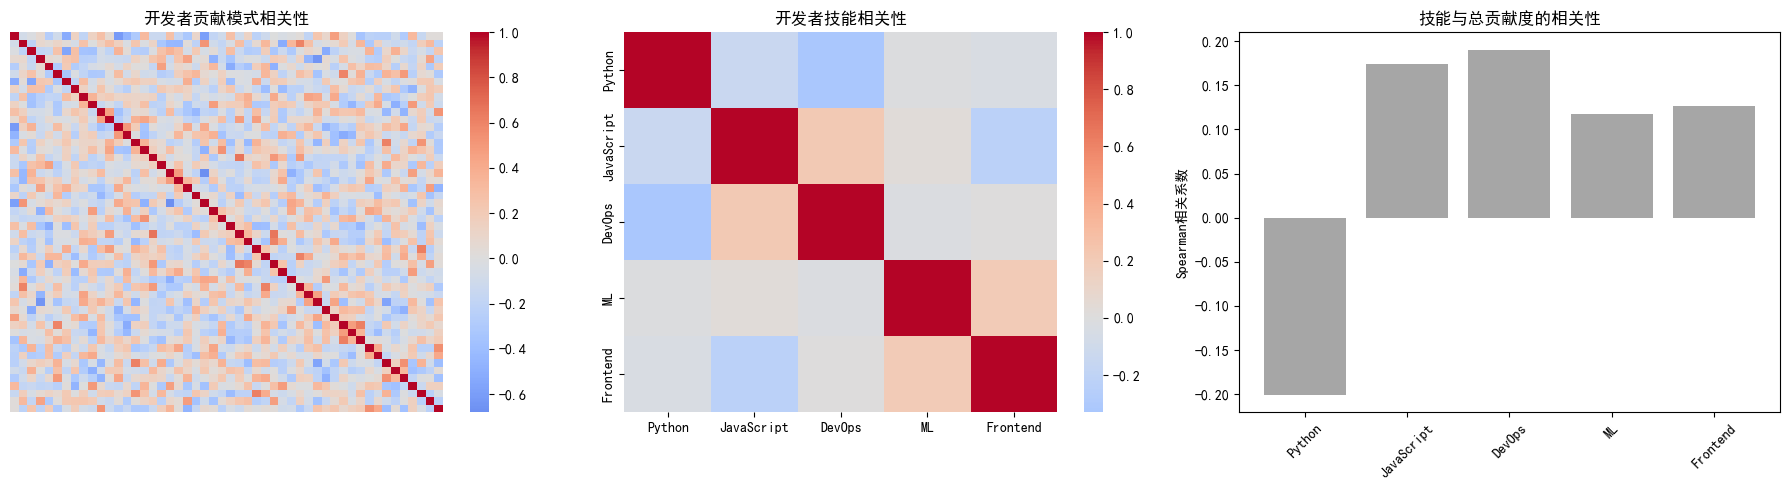


技能与贡献度相关性分析:
Python: 相关系数=-0.201, p值=0.161 (不显著)
JavaScript: 相关系数=0.175, p值=0.225 (不显著)
DevOps: 相关系数=0.191, p值=0.185 (不显著)
ML: 相关系数=0.117, p值=0.418 (不显著)
Frontend: 相关系数=0.126, p值=0.382 (不显著)


In [3]:
def correlation_analysis(contributions, dev_skills):
    """
    进行相关性分析
    """
    print("=== 相关性分析 ===")
    
    # 1. 开发者贡献度相关性
    dev_contribution_corr = np.corrcoef(contributions)
    
    # 2. 技能相关性
    skill_correlation = np.corrcoef(dev_skills.T)
    
    # 3. 贡献度与技能的相关性
    total_contributions = np.sum(contributions, axis=1)
    skill_contribution_corr = []
    for i in range(dev_skills.shape[1]):
        corr, p_value = spearmanr(dev_skills[:, i], total_contributions)
        skill_contribution_corr.append((corr, p_value))
    
    # 可视化
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 开发者贡献相关性热图
    sns.heatmap(dev_contribution_corr, ax=axes[0], cmap='coolwarm', 
                center=0, xticklabels=False, yticklabels=False)
    axes[0].set_title('开发者贡献模式相关性')
    
    # 技能相关性热图
    skill_labels = ['Python', 'JavaScript', 'DevOps', 'ML', 'Frontend']
    sns.heatmap(skill_correlation, ax=axes[1], cmap='coolwarm', center=0,
                xticklabels=skill_labels, yticklabels=skill_labels)
    axes[1].set_title('开发者技能相关性')
    
    # 技能与贡献度的相关性
    skills = skill_labels
    correlations = [corr for corr, p in skill_contribution_corr]
    p_values = [p for corr, p in skill_contribution_corr]
    
    colors = ['red' if p < 0.05 else 'gray' for p in p_values]
    bars = axes[2].bar(skills, correlations, color=colors, alpha=0.7)
    axes[2].set_title('技能与总贡献度的相关性')
    axes[2].set_ylabel('Spearman相关系数')
    axes[2].tick_params(axis='x', rotation=45)
    
    # 添加显著性标记
    for i, (corr, p) in enumerate(skill_contribution_corr):
        if p < 0.05:
            axes[2].text(i, corr + 0.02 * np.sign(corr), '*', 
                        ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计结果
    print("\n技能与贡献度相关性分析:")
    for i, (skill, (corr, p)) in enumerate(zip(skill_labels, skill_contribution_corr)):
        significance = "显著" if p < 0.05 else "不显著"
        print(f"{skill}: 相关系数={corr:.3f}, p值={p:.3f} ({significance})")
    
    return dev_contribution_corr, skill_correlation, skill_contribution_corr

# 执行相关性分析
dev_corr, skill_corr, skill_cont_corr = correlation_analysis(contributions, dev_skills)

=== 层次聚类分析 ===


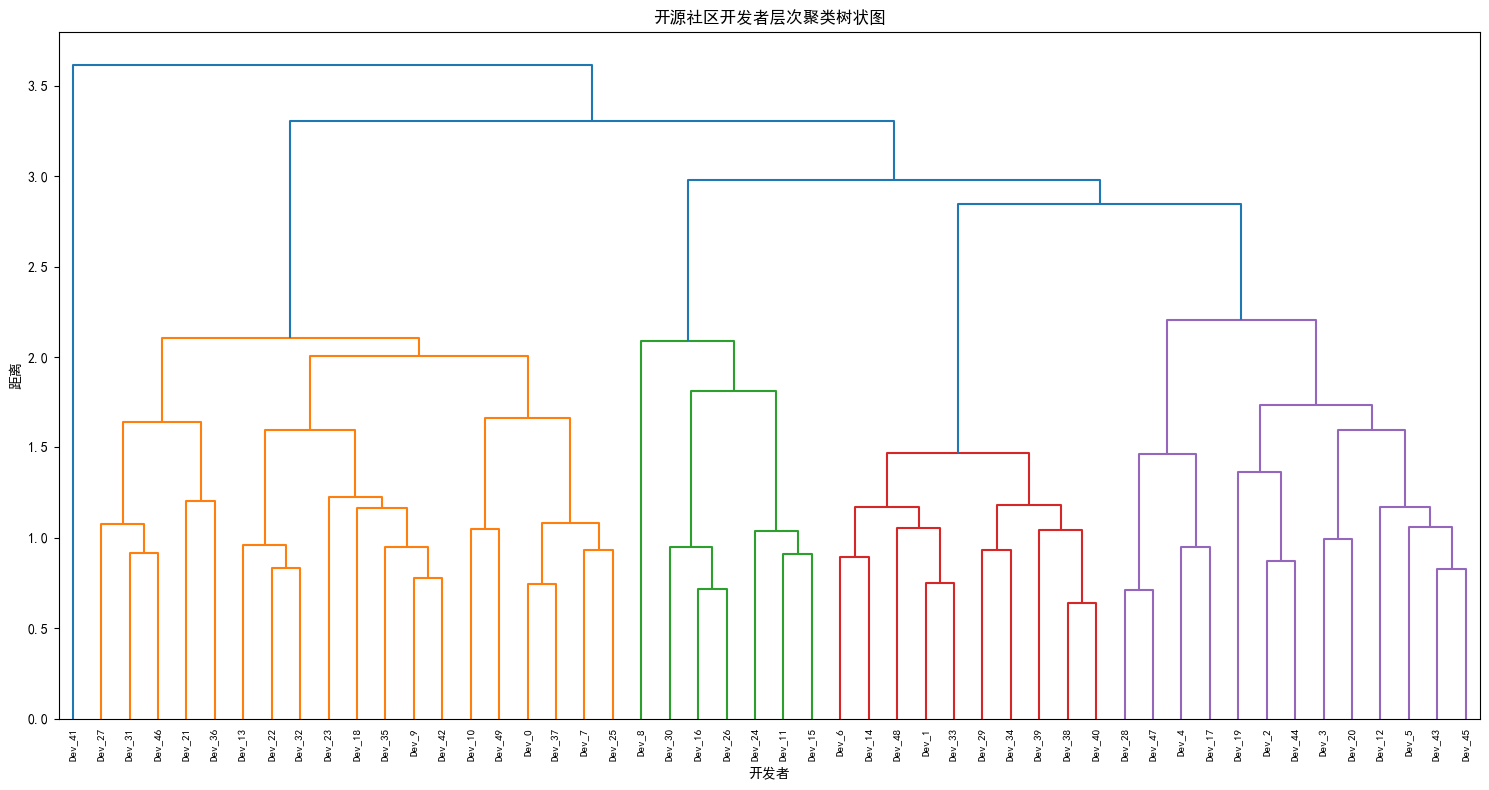

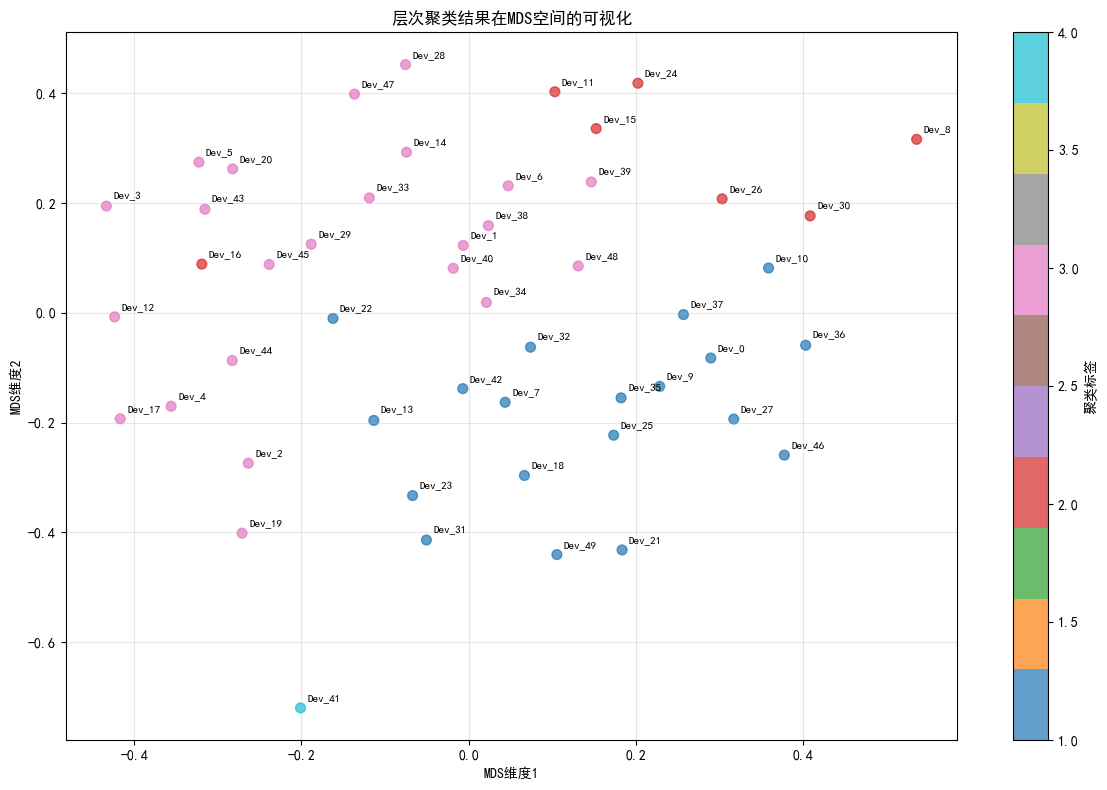


=== 聚类特征分析 ===

--- 聚类 1 ---
成员数量: 19
成员: [ 0  7  9 10 13 18 21 22 23 25 27 31 32 35 36 37 42 46 49]
平均技能水平:
  Python: 0.510
  JavaScript: 0.550
  DevOps: 0.671
  ML: 0.550
  Frontend: 0.478
平均每个成员贡献度: 67.84
主要贡献项目: [ 8  5 11]

--- 聚类 2 ---
成员数量: 7
成员: [ 8 11 15 16 24 26 30]
平均技能水平:
  Python: 0.681
  JavaScript: 0.477
  DevOps: 0.174
  ML: 0.331
  Frontend: 0.452
平均每个成员贡献度: 49.00
主要贡献项目: [ 3 15 18]

--- 聚类 3 ---
成员数量: 23
成员: [ 1  2  3  4  5  6 12 14 17 19 20 28 29 33 34 38 39 40 43 44 45 47 48]
平均技能水平:
  Python: 0.468
  JavaScript: 0.444
  DevOps: 0.484
  ML: 0.509
  Frontend: 0.460
平均每个成员贡献度: 64.26
主要贡献项目: [19 14  9]

--- 聚类 4 ---
成员数量: 1
成员: [41]
平均技能水平:
  Python: 0.009
  JavaScript: 0.101
  DevOps: 0.664
  ML: 0.005
  Frontend: 0.161
平均每个成员贡献度: 6.00
主要贡献项目: [ 5  4 19]


In [4]:
def hierarchical_clustering(contributions, similarity_matrix):
    """
    进行层次聚类分析
    """
    print("=== 层次聚类分析 ===")
    
    # 使用相似性矩阵进行层次聚类
    # 将相似性转换为距离
    distance_matrix = 1 - similarity_matrix
    
    # 执行层次聚类
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # 绘制树状图
    plt.figure(figsize=(15, 8))
    dendrogram(linkage_matrix, 
               labels=[f'Dev_{i}' for i in range(len(contributions))],
               leaf_rotation=90,
               leaf_font_size=8)
    plt.title('开源社区开发者层次聚类树状图')
    plt.xlabel('开发者')
    plt.ylabel('距离')
    plt.tight_layout()
    plt.show()
    
    # 确定聚类结果 (例如分为4类)
    n_clusters = 4
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # 可视化聚类结果在MDS图上
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(mds_coords[:, 0], mds_coords[:, 1], 
                         c=clusters, cmap='tab10', s=50, alpha=0.7)
    
    for i, cluster in enumerate(clusters):
        plt.annotate(f'Dev_{i}', (mds_coords[i, 0], mds_coords[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.colorbar(scatter, label='聚类标签')
    plt.title('层次聚类结果在MDS空间的可视化')
    plt.xlabel('MDS维度1')
    plt.ylabel('MDS维度2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 分析每个聚类的特征
    cluster_analysis(contributions, dev_skills, clusters)
    
    return linkage_matrix, clusters

def cluster_analysis(contributions, dev_skills, clusters):
    """
    分析每个聚类的特征
    """
    print("\n=== 聚类特征分析 ===")
    
    unique_clusters = np.unique(clusters)
    skill_labels = ['Python', 'JavaScript', 'DevOps', 'ML', 'Frontend']
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        cluster_members = np.where(cluster_mask)[0]
        cluster_contributions = contributions[cluster_mask]
        cluster_skills = dev_skills[cluster_mask]
        
        print(f"\n--- 聚类 {cluster_id} ---")
        print(f"成员数量: {len(cluster_members)}")
        print(f"成员: {cluster_members}")
        
        # 平均技能水平
        avg_skills = np.mean(cluster_skills, axis=0)
        print("平均技能水平:")
        for skill, level in zip(skill_labels, avg_skills):
            print(f"  {skill}: {level:.3f}")
        
        # 贡献模式
        total_cluster_contrib = np.sum(cluster_contributions)
        avg_contribution_per_member = total_cluster_contrib / len(cluster_members)
        print(f"平均每个成员贡献度: {avg_contribution_per_member:.2f}")
        
        # 主要贡献项目
        project_contributions = np.sum(cluster_contributions, axis=0)
        main_projects = np.argsort(project_contributions)[-3:][::-1]
        print("主要贡献项目:", main_projects)

# 执行层次聚类
linkage_mat, cluster_labels = hierarchical_clustering(contributions, similarity_mat)

=== 综合网络分析 ===
网络节点数: 50
网络边数: 1219
网络密度: 0.995

度中心性前5的开发者:
  开发者 0: 1.000
  开发者 1: 1.000
  开发者 2: 1.000
  开发者 4: 1.000
  开发者 5: 1.000

中介中心性前5的开发者:
  开发者 0: 0.000
  开发者 1: 0.000
  开发者 2: 0.000
  开发者 4: 0.000
  开发者 5: 0.000


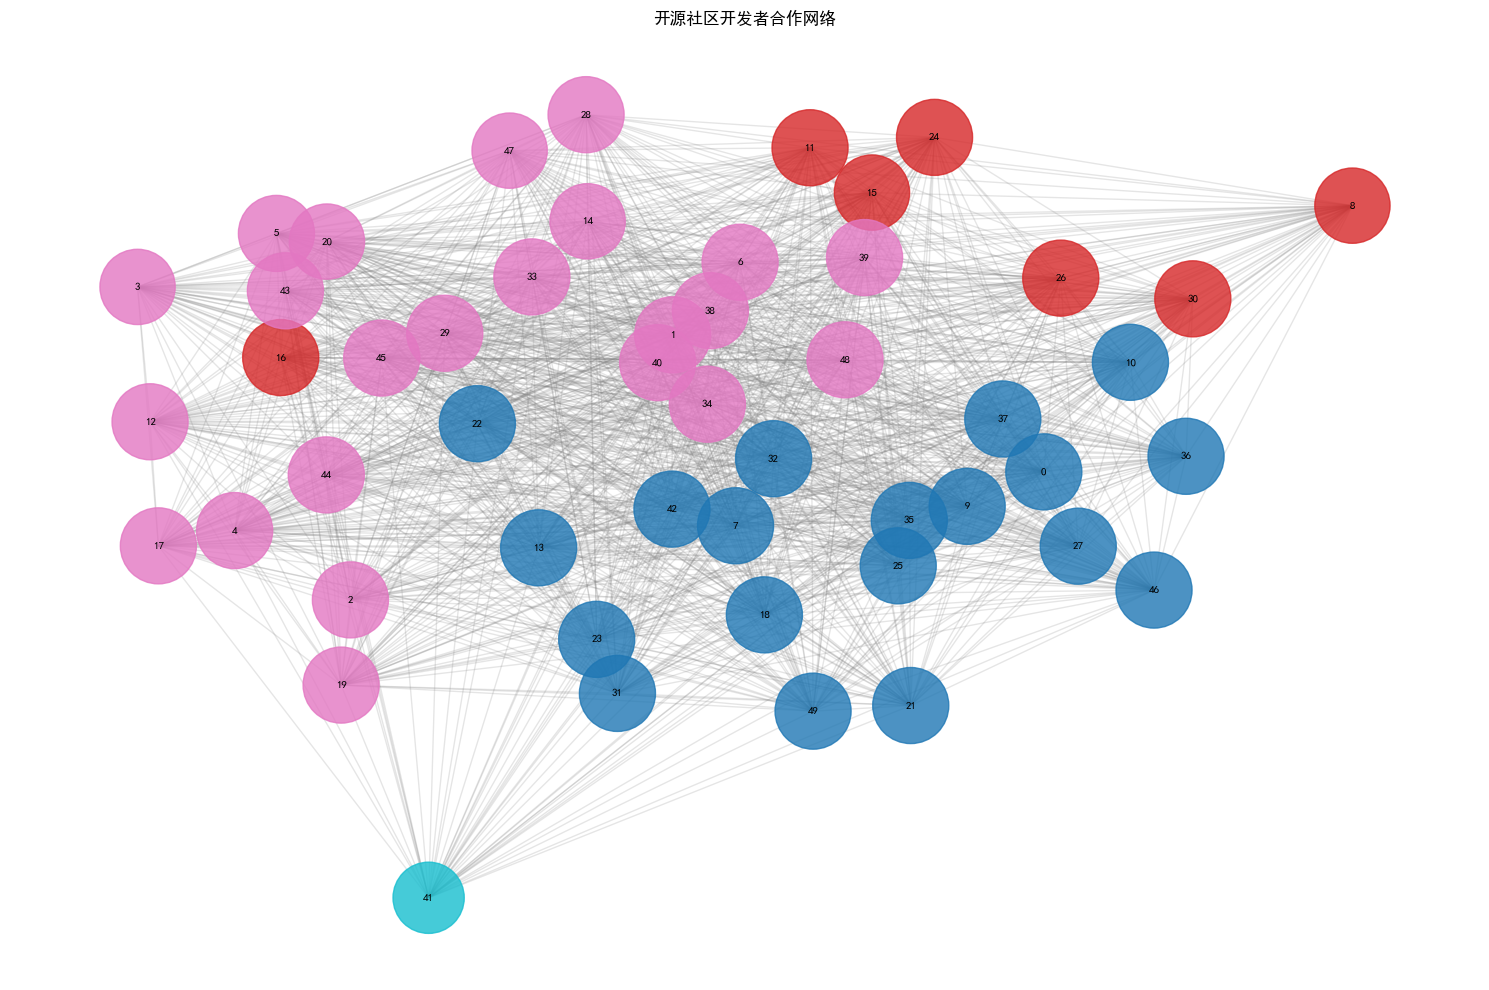

In [5]:
def comprehensive_network_analysis(contributions, dev_skills):
    """
    综合网络分析
    """
    print("=== 综合网络分析 ===")
    
    # 构建开发者合作网络
    G = nx.Graph()
    
    # 添加节点
    n_developers = contributions.shape[0]
    for i in range(n_developers):
        G.add_node(i, total_contributions=np.sum(contributions[i]))
    
    # 添加边 (基于共同贡献的项目)
    for proj_idx in range(contributions.shape[1]):
        contributors = np.where(contributions[:, proj_idx] > 0)[0]
        for i in range(len(contributors)):
            for j in range(i+1, len(contributors)):
                if G.has_edge(contributors[i], contributors[j]):
                    G[contributors[i]][contributors[j]]['weight'] += 1
                else:
                    G.add_edge(contributors[i], contributors[j], weight=1)
    
    # 计算网络指标
    print(f"网络节点数: {G.number_of_nodes()}")
    print(f"网络边数: {G.number_of_edges()}")
    print(f"网络密度: {nx.density(G):.3f}")
    
    # 度中心性
    degree_centrality = nx.degree_centrality(G)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\n度中心性前5的开发者:")
    for dev, centrality in top_degree:
        print(f"  开发者 {dev}: {centrality:.3f}")
    
    # 中介中心性
    betweenness_centrality = nx.betweenness_centrality(G)
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\n中介中心性前5的开发者:")
    for dev, centrality in top_betweenness:
        print(f"  开发者 {dev}: {centrality:.3f}")
    
    # 可视化网络
    plt.figure(figsize=(15, 10))
    
    # 使用MDS坐标进行网络布局
    pos = {i: mds_coords[i] for i in range(n_developers)}
    
    # 节点大小基于度中心性
    node_sizes = [3000 * degree_centrality[i] for i in range(n_developers)]
    
    # 节点颜色基于聚类
    node_colors = cluster_labels
    
    # 绘制网络
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color=node_colors, cmap='tab10', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title('开源社区开发者合作网络')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

# 执行综合网络分析
network_graph = comprehensive_network_analysis(contributions, dev_skills)